# **Assignment 4**
### by Group 9

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pymc3 as pm
from pymc3.ode import DifferentialEquation

# setting global random seed
np.random.seed(15)

# ignore warnings
import warnings
warnings.filterwarnings("ignore") 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Task
- on the basis of provided code for estimating the basic reproduction number ($R_{0}$) based on noisy and sparse data time-series data for $I(t)$ and $R(t)$ in an SIR model, change the program to represent an SIRD model by including ($D$)eaths with the mortality rate $\mu$
- fix $\gamma=1$ and $\beta=2.5$
- **infer the mortality rate $\mu$ given noisy $S(t)$, $I(t)$, $R(t)$, $D(t)$ input curves**
- optional: optimze the code
- optional: does the inference for $\mu$ work, if $S(t)$ and/or $R(t)$ are not given?
- you may use these (initial) conditions/parameters (compartment sized in fractions): $S(0) = 0.99$, $I(0) = 0.01$, $R(0) = 0$, $D(0) = 0$
- you may assume values for the respective log-normal noises to lie in the range of 0.2-0.4 ($\sigma \in [0.2, 0.4]$) but not lower than 0.1

## SIRD model

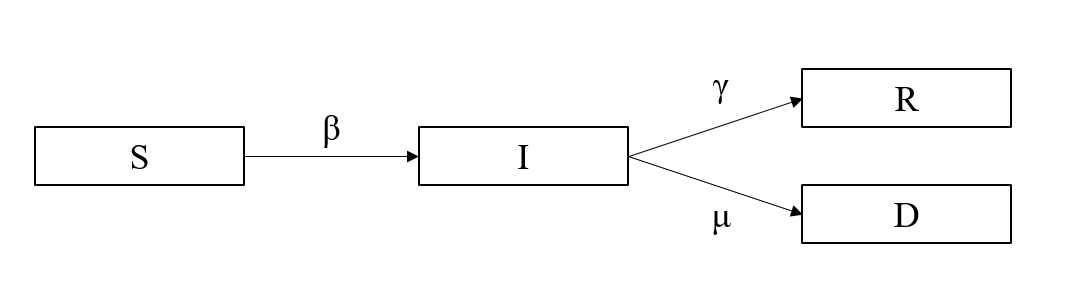

**list of components of the SIRD model:**

$N$: total population set to 1

$S(t)$: percentage of people susceptible on day t

$I(t)$: percentage of people infected on day t

$R(t)$: percentage of people recovered on day t

$D(t)$: percentage of people dead on day t**


$R_{0}$: basic reproduction number

$R_{e}(t)$: effective reproduction number

$\beta$: infection rate

$\gamma$: recovery rate 

$\mu$: mortality rate


**ODEs**
- $\frac{dS}{dt} = -\beta * I * \frac{S}{N} $
- $\frac{dI}{dt} = \beta * I \frac{S}{N} - \gamma * I -\mu * I$
- $\frac{dR}{dt} = \gamma * I $
- $\frac{dD}{dt} = \mu * I$

first, we need to define the initial compartment conditions of the SIRD model ...

In [2]:
# 1% infected at time t=0
i0 = 0.01 

# 0% recovered at time t=0
r0 = 0.00 

# 0% deceased at time t=0 
d0 = 0

# fix beta
beta = 2.5

# fix gamma
gamma = 1

# setting mu (ground truth), to be estimated using MCMC
mu = 0.25

# define ODEs
def SIRD(y, t, p):
    # we do not need susceptibles as S=1-I-R-D is dependent on I, R and D
    # ds = ... 
    
    # p[0]=mu, N=1, S=N-I-R-D, y[1]=I, y[0]=R, y[2]=D, p[0]=mu, gamma=1  
    di = beta*y[1]*(1-y[1]-y[0]-y[2]) - gamma * y[1]- p[0] * y[1] 
        
    # gamma=1, y[1]=I
    dr = gamma * y[1] 
    
    # p[0]=mu, y[1]=I
    dd = p[0] * y[1] 
    
    # return r(ecovered) and i(nfected)
    return [dr, di, dd] 

Now, we can define the relevant parameters for the time dimension ...

In [3]:
# time factor defining total time window range, increase interpretability by changing from 3 to 8 
f = 1 + 7 # initial point in time + days of the week 

# time steps (e.g., daily) increase interpretability by changing from 0.5 to 1
timestep_data = 1

# contstruct time axis
times = np.arange(0,f,timestep_data)

The ODE system can now be integrated yielding the compartment sizes for each timestep ..

In [4]:
# create SIRD curves
y = odeint(SIRD, t=times, y0=[r0, i0, d0], args=([mu],), rtol=1e-8)

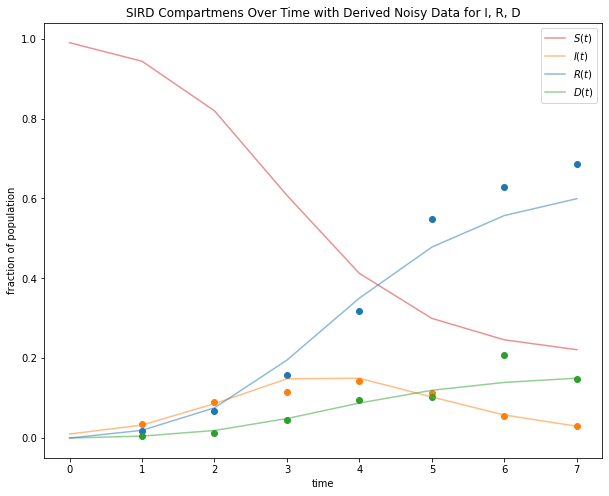

In [5]:
# reset seed to guarantee same results when rerunning single cell
np.random.seed(15)

# observational model for muliplicative noise with specified sigmas
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.20, 0.225, 0.25])

# plot the deterministic curves and those with multiplicative noise
plt.figure(figsize=(10,8))
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, 1 - y[:,0] - y[:,1] - y[:,2], color ='C3', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')
plt.xlabel("time")
plt.ylabel("fraction of population")
plt.title("SIRD Compartmens Over Time with Derived Noisy Data for I, R, D")
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Tkeaway:</b> 
    
- we can see the usual SIRD curve behavior when looking at the resulting lines
    
- despite not specifying the $S$ curve directly we can infer it from the other curves
    
- the newly created noisy data for $I$, $R$ and $D$ follows the actual curves with significant noise introduced via $\sigma$s
    
</div>

## MCMC estimation of $\mu$

Let's estimate $\mu$ using MCMC sampling ...

logp = -6.1215, ||grad|| = 0.0075763: 100%|████████████████████████████████████████████| 15/15 [00:01<00:00, 14.23it/s]
Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [mortality, sigma]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████████| 900/900 [04:07<00:00,  3.64it/s]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[0],2.23,0.63,1.19,3.24,0.03,0.02,585.0,470.0,753.0,483.0,1.00
sigma[1],2.96,0.84,1.61,4.46,0.03,0.02,658.0,567.0,784.0,543.0,1.01
sigma[2],3.38,0.89,1.92,4.96,0.04,0.03,482.0,472.0,524.0,603.0,1.00
mortality,0.17,0.09,0.01,0.31,0.00,0.00,609.0,609.0,461.0,195.0,1.00


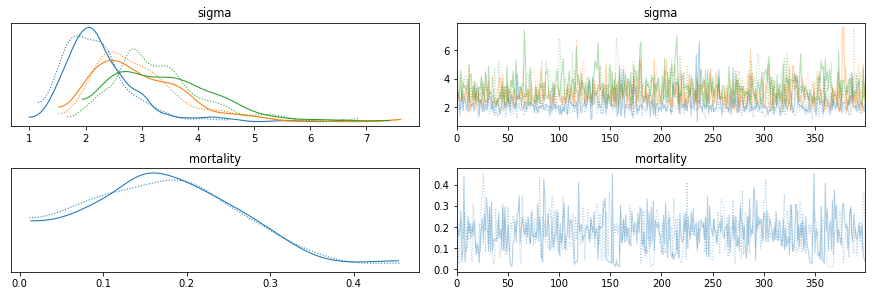

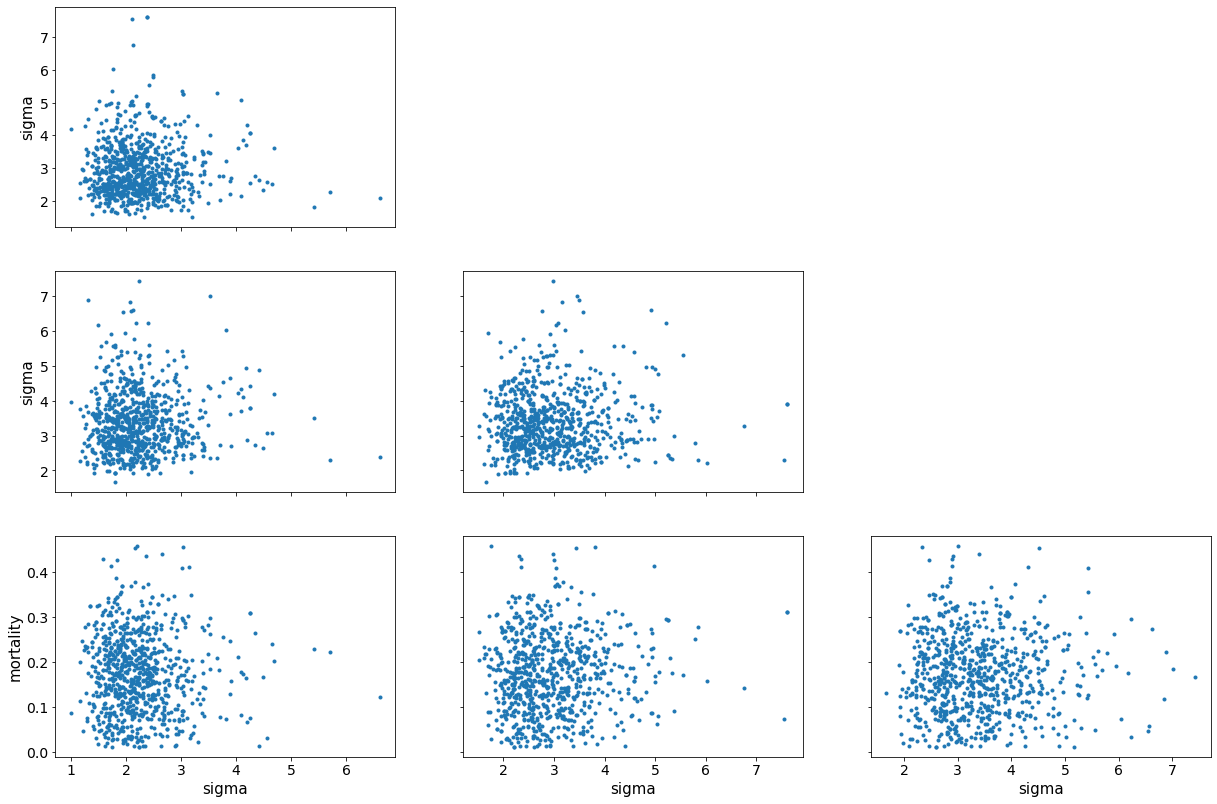

In [6]:
# ODE system container
sird_model = DifferentialEquation(
    # SIRD ODE
    func = SIRD,
    # start at t0=1
    times = np.arange(timestep_data, f, timestep_data), 
    # 3 states: I, R, D
    n_states = 3, 
    # mu is the only parameter to be estimated
    n_theta = 1, 
    # start from zero
    t0 = 1 
    )

# define and perform MCMC
with pm.Model() as basic_model:

    # distribution of variances (sigma[0], sigma[1] and sigma[2])  
    sigma = pm.HalfCauchy("sigma", 1, shape=3)

    # guess pior: mu is bounded (0,1) (mean = 0.15, sigma = 1)
    mortality = pm.Bound(pm.Normal, lower=0.01, upper=0.75)("mortality", mu = 0.15, sigma = 0.1)

    # deterministic SIRD curves
    sird_curves = sird_model(y0=[r0, i0, d0], theta=[mortality])

    # likelihood function: sampling distribution for noise around the I, R and D curves, variances via sigmas, data=yobs
    Y = pm.Lognormal("Y",
                     # pm.math.log(sird_curves) would yield infinite Y values
                     mu =  sird_curves, 
                     # variances
                     sd=sigma,
                     # data
                     observed=yobs
                    ) 
    
    start = pm.find_MAP()
    step = pm.NUTS()
    
    trace = pm.sample(400, step=step, random_seed=25, cores=1) 

# plot results
pm.traceplot(trace)
pm.pairplot(trace)
pm.summary(trace).round(2)

<div class="alert alert-block alert-success">
<b>Takeaway:</b> 

- compared to previously specified $\sigma$s 0.20, 0.225, 0.25 we see that their distinctiveness is recognized (3 distinctive distributions)
    
- based on our ground truth knwoledge about the actual mortality rate $\mu = 0.25$, with a prior distribution of $\mu$ (mean is 0.15), we can see that the posterior distribution has a mean of 0.17, which has "moved", at least to some degree, closer to the actual value 0.25
    
- the underwhelming results could be due to the impossible handling of pm.math.log(sird_curves) and the substitute solution using the "naked" sird_curve
    
</div>

### Extra: does the inference for $\mu$ work, if $S(t)$ or $R(t)$ are not given?

$S$ was not already not given in the analysis, so let's try the same for $R$ now ...

In [7]:
# 99% susceptible at time t=0
s0 = 0.99 

# 1% infected at time t=0
i0 = 0.01 

# 0% deceased at time t=0 initially
d0 = 0

# setting mu (ground truth), to be estimated using MCMC, as previously set
mu = 0.25

# define ODEs
def SIRD_no_R(y, t, p):
    # y[1] = I, y[0] = S
    ds = -beta*y[1]*y[0] 
    
    # p[0]=mu, N=1, S=N-I-R-D, y[1]=I, y[0]=S, y[2]=D, p[0]=mu, gamma=1  
    di = beta*y[1]*y[0] - gamma * y[1]- p[0] * y[1] 
        
    # excluded
    # dr = ... 
    
    # p[0]=mu, y[1]=I
    dd = p[0] * y[1] 
    
    # return r(ecovered) and i(nfected)
    return [ds, di, dd] 

The ODE system can now be integrated yielding the compartment sizes for each timestep ..

In [8]:
# create SIRD curves
y_no_R = odeint(SIRD_no_R, t=times, y0=[s0, i0, d0], args=([mu],), rtol=1e-8)

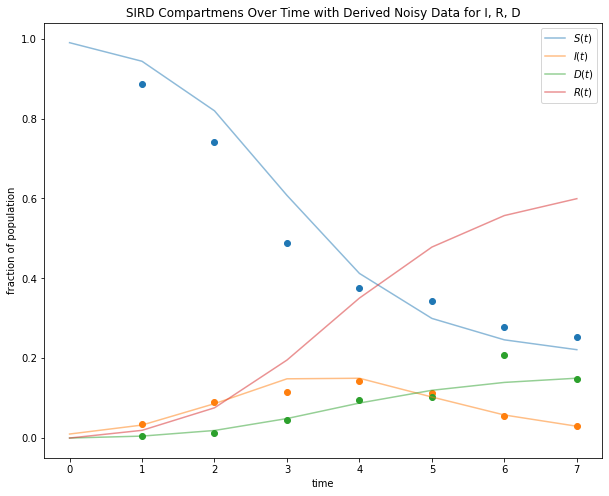

In [9]:
# reset seed to guarantee same results when rerunning single cell
np.random.seed(15)

# observational model for muliplicative noise with specified sigmas
yobs_no_R = np.random.lognormal(mean=np.log(y_no_R[1::]), sigma=[0.20, 0.225, 0.25])

# plot the deterministic curves and those with multiplicative noise
plt.figure(figsize=(10,8))
plt.plot(times[1::],yobs_no_R, marker='o', linestyle='none')
plt.plot(times, y_no_R[:,0], color ='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y_no_R[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y_no_R[:,2], color='C2', alpha=0.5, label=f'$D(t)$')
plt.plot(times, 1 - y_no_R[:,0] - y_no_R[:,1] - y_no_R[:,2], color ='C3', alpha=0.5, label=f'$R(t)$')
plt.xlabel("time")
plt.ylabel("fraction of population")
plt.title("SIRD Compartmens Over Time with Derived Noisy Data for I, R, D")
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Takeaway:</b> 
    
- we can see the usual SIRD curve behavior when looking at the resulting lines
    
- without specifying the $R$ curve directly we can infer it from the other curves
    
- the newly created noisy data for $S$, $I$, and $D$ follows the actual curves with significant noise introduced via $\sigma$s
    
</div>

Let's estimate $\mu$ using MCMC sampling ...

logp = -4.3209, ||grad|| = 0.0023743: 100%|████████████████████████████████████████████| 15/15 [00:00<00:00, 24.09it/s]
Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [mortality, sigma]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████████| 900/900 [02:18<00:00,  6.51it/s]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[0],1.03,0.30,0.58,1.56,0.01,0.01,508.0,417.0,716.0,386.0,1.01
sigma[1],2.83,0.78,1.59,4.43,0.03,0.02,554.0,492.0,721.0,484.0,1.01
sigma[2],3.43,0.92,1.90,5.16,0.05,0.03,382.0,373.0,457.0,556.0,1.01
mortality,0.16,0.09,0.02,0.31,0.00,0.00,592.0,592.0,501.0,312.0,1.00


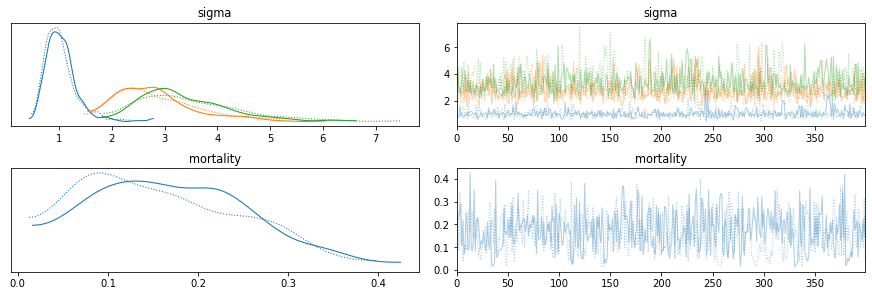

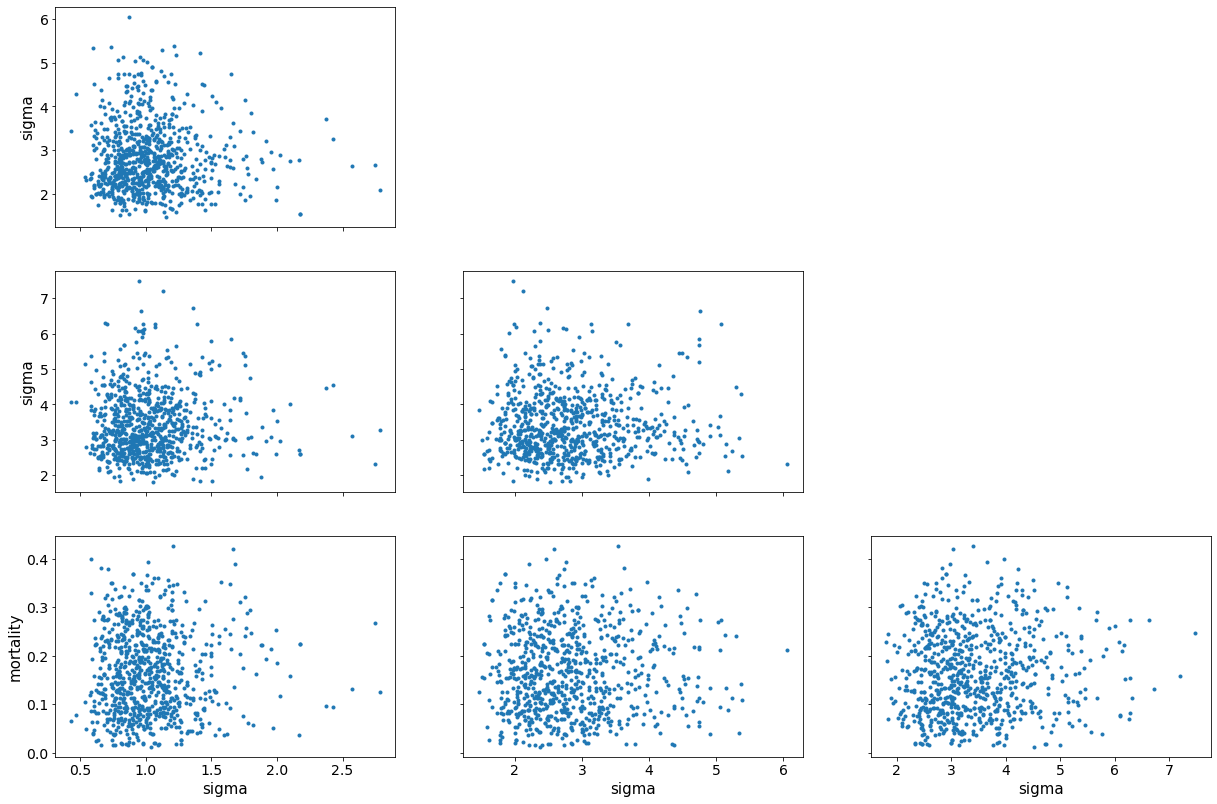

In [10]:
# ODE system container
sird_model = DifferentialEquation(
    # SIRD ODE
    func = SIRD_no_R,
    # start at t0=1
    times = np.arange(timestep_data, f, timestep_data), 
    # 2 states: I, D
    n_states = 3, 
    # mu is the only parameter to be estimated
    n_theta = 1, 
    # start from zero
    t0 = 1 
    )

# define and perform MCMC
with pm.Model() as basic_model:

    # distribution of variances (sigma[0] and sigma[1])  
    sigma = pm.HalfCauchy("sigma", 1, shape=3)

    # guess pior: mu is bounded (0,1) (mean = 0.15, sigma = 1)
    mortality = pm.Bound(pm.Normal, lower=0.01, upper=0.75)("mortality", mu = 0.15, sigma = 0.1)

    # deterministic SIRD curves
    sird_curves = sird_model(y0=[r0, i0, d0], theta=[mortality])

    # likelihood function: sampling distribution for noise around the I, R and D curves, variances via sigmas, data=yobs
    Y = pm.Lognormal("Y",
                     # pm.math.log(sird_curves) would yield infinite Y values
                     mu = sird_curves, 
                     # variances
                     sd=sigma,
                     # data
                     observed=yobs_no_R
                    ) 
    
    start = pm.find_MAP()
    step = pm.NUTS()
    
    trace = pm.sample(400, step=step, random_seed=25, cores=1) 

# plot results
pm.traceplot(trace)
pm.pairplot(trace)
pm.summary(trace).round(2)

<div class="alert alert-block alert-success">
<b>Takeaway:</b> 

- again, compared to previously specified $\sigma$s 0.20, 0.225, 0.25 we see that their distinctiveness is recognized (3 distinctive distributions)
    
- based on our ground truth knwoledge about the actual mortality $\mu = 0.25$, with a prior distribution of $\mu$ (mean is 0.15), we can see that the posterior mean of 0.16 "moved", at least to some degree, closer to the actual value
    
- interestingly, the posterior exhibits a significant positive bump between 0.2 and 0.3 which might indicate the capturing of the axctual ground truth
    
- the underwhelming results could be due to the impossible handling of pm.math.log(sird_curves) and the substitute solution using the "naked" sird_curve
    
</div>